## Compute Crawling metrics

In [34]:
import os
import pandas as pd
from utils.crawleval import evaluate_crawling_metrics

In [2]:
def save_crawl_metrics(cmetrics_df: pd.DataFrame, fpath: str, tested_limits: list):
    records = []
    for exp_name, metrics_list in cmetrics_df.items():
        for limit, metrics in zip(tested_limits, metrics_list):
            for metric_name, value in metrics.items():
                records.append({
                    'experiment': exp_name,
                    'metric': metric_name,  
                    'limit': limit,
                    metric_name: value  
                })
    df = pd.DataFrame(records)

    df = df.drop(columns=['metric'])

    df.to_csv(fpath, index=False, sep='\t')
    print(df.head())
    return df

def merge_with_old_dict(cmetrics_dict: dict, path_to_old_cmetrics: str, metric_name: str) -> pd.DataFrame:
    if not os.path.exists(path_to_old_cmetrics):
        return cmetrics_dict
    old_crawl_metrics = pd.read_csv(path_to_old_cmetrics, sep="\t")
    old_crawl_metrics.head()
    old_dict = {}
    for experiment, group in old_crawl_metrics.groupby('experiment'):
        metric_list = [{metric_name: value} for value in group[metric_name]]
        old_dict[experiment] = metric_list

    old_dict.update(cmetrics_dict)
    return old_dict

In [2]:
benchmark_names = {"msmarco-ws": "MSM-WS", "rq": "RQ"} # , , 

tested_exps = {"pagerank_orig": "PageRank"}#{"fifo": "BFS", "pagerank_orig": "PageRank", "oracle-quality_new": "Qoracle", "quality_ft": "Qfirst", "quality_deprioritised": "Qmin"}#"quality_ft": "Quality (new)", "quality_deprioritised": "Quality (deprioritised)"}#{"fifo": "BFS", "oracle-quality_new": "Qoracle", "quality_ft": "Qfirst", "quality_deprioritised": "Qmin"}#"quality_ft": "Quality (new)", "quality_deprioritised": "Quality (deprioritised)"}
MIN_LIMIT_VAL = 2_500_000
MAX_LIMIT_VAL = 29_261_138
INTERVAL = 2_500_000

tested_limits = list(range(MIN_LIMIT_VAL, MAX_LIMIT_VAL + 1, INTERVAL))
tested_limits = tested_limits + ([MAX_LIMIT_VAL] if MAX_LIMIT_VAL not in tested_limits else [])
tested_metrics = {"maxndcg": "MaxNDCG"}#{"harvest": "Relevant Harvest Rate"}#{"nrel": "MaxNDCG"} #, "harvest": "Relevant Harvest Rate"
#tested_metrics = {"nrel": "nrel"}

ttest = False

In [ ]:
# compute crawl metrics
for benchmark_name in benchmark_names:
    print("Processing benchmark:", benchmark_name)
    tested_benchmarks = [benchmark_name]
    all_crawl_metrics = evaluate_crawling_metrics(tested_benchmarks, tested_exps, tested_limits, target_metrics=tested_metrics.keys(), aggregate=True)

    for metric_name, printable_m_name in tested_metrics.items():
        if not ttest:
            path_to_cmetrics = f"crawling_metrics_{benchmark_name}_{metric_name}.csv"
        else:
            path_to_cmetrics = f"crawling_metrics_{benchmark_name}_{metric_name}_t-test.csv"
        
        joined_dict = merge_with_old_dict(all_crawl_metrics, path_to_cmetrics, metric_name)
        df_crawl = save_crawl_metrics(joined_dict, path_to_cmetrics, tested_limits=tested_limits)

        # filter out experiments not tested
        df_crawl = df_crawl[df_crawl['experiment'].isin(tested_exps.keys())]
        print(df_crawl.head())

## Plot effectiveness metrics during time

In [35]:
import pandas as pd
from plots.functions_harvest import plot_multiple_cmetric_across_limits

def plot_cmetrics_comparison(metric_dict: dict, tested_exps: dict, ttest: bool = True, ydecmillions: bool = True, leg_pos="lower right"):
    metric_name = list(metric_dict.keys())[0]
    printable_m_name = metric_dict[metric_name]

    all_dfs_crawl_dict = {}
    for benchmark_name, printable_b_name in benchmark_names.items():
        if not ttest:
            path_to_cmetrics = f"./../../data/csv/crawling_metrics_{benchmark_name}_{metric_name}.csv"
        else:
            path_to_cmetrics = f"./../../data/csv/crawling_metrics_{benchmark_name}_{metric_name}_t-test.csv"
            
        df_crawl = pd.read_csv(path_to_cmetrics, sep="\t")
        # filter out experiments not tested and filter out other metrics
        df_crawl = df_crawl[df_crawl['experiment'].isin(tested_exps.keys())]
        all_dfs_crawl_dict[printable_b_name] = df_crawl

    fig = plot_multiple_cmetric_across_limits(all_dfs_crawl_dict, exp_dict=tested_exps, metric=metric_name, printable_metric=printable_m_name, ubs_hr=None, ydecmillions=ydecmillions, leg_pos=leg_pos, sharey=False, leg_ncol=1, grid='y', figsize=(5,3), linewidth=2, markersize=6, ttest=ttest)
    fig.show()
    fig.savefig(fname=f"{metric_name}_all_benchmarks.pdf", format='pdf', bbox_inches='tight')

In [36]:
tested_metrics = {"maxndcg": "MaxNDCG"}#{"harvest": "Harvest Rate"}#{"nDCG@10": "nDCG@10"}#{"maxndcg": "MaxNDCG"}#{"nDCG@10": "nDCG@10"} #{"maxndcg": "MaxNDCG"} #{"harvest": "Harvest Rate"}#{"nDCG@10": "nDCG@10"} # "maxndcg": "MaxNDCG", "nDCG@10": "nDCG@10"
ttest = True

benchmark_names = {"msmarco-ws": "MSM-WS", "rq": "RQ"}
tested_exps = {"fifo": "BFS", "oracle-quality_new": "QOracle", "quality_ft": "QFirst", "quality_deprioritised": "QMin"}
MIN_LIMIT_VAL = 2_500_000
MAX_LIMIT_VAL = 29_261_138
INTERVAL = 2_500_000
tested_limits = sorted(list(range(MIN_LIMIT_VAL, MAX_LIMIT_VAL + 1, INTERVAL)) + [MAX_LIMIT_VAL])

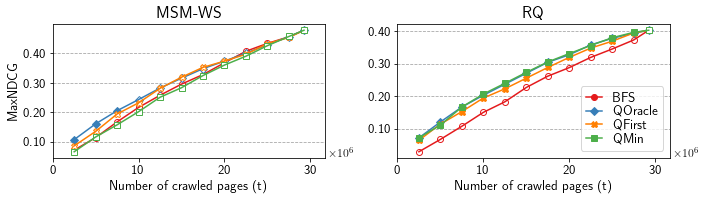

In [37]:
tested_metrics = {"maxndcg": "MaxNDCG"}
plot_cmetrics_comparison(tested_metrics, tested_exps, ttest=ttest, ydecmillions=False)

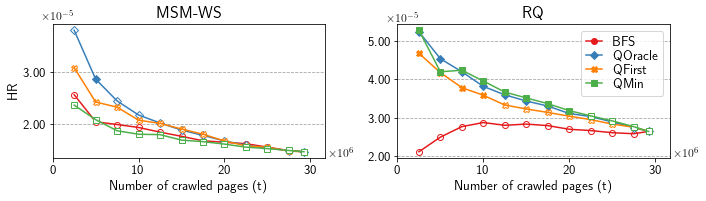

In [38]:
tested_metrics = {"harvest": "HR"}
plot_cmetrics_comparison(tested_metrics, tested_exps, ttest=ttest, ydecmillions=True, leg_pos="upper right")

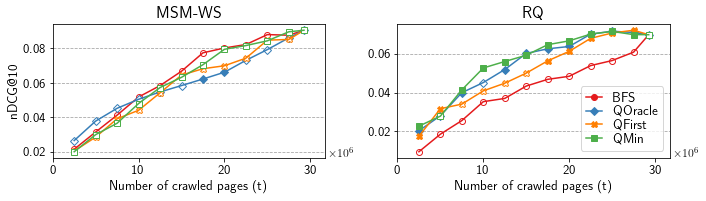

In [39]:
tested_metrics = {"nDCG@10": "nDCG@10"}
plot_cmetrics_comparison(tested_metrics, tested_exps, ttest=ttest, ydecmillions=False)